#### Team members:

* Swaroop Bhandary K
* Deepansh Pandey

In [1]:
import torch
import numpy as np
import os

from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import save_image

torch.random.manual_seed(1)
np.random.seed(1)

cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.random.manual_seed(1)
    print("using gpu")
    aDev = torch.device("cuda")
else:
    aDev = torch.device("cpu")

using gpu


In [2]:
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor

def tensor_round(tensor):
    return torch.round(tensor)

trsfm = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.4914, 0.4822, 0.4465],
                                                 [0.247, 0.243, 0.261]),
                            transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
                            transforms.Lambda(lambda tensor:tensor_round(tensor))                            
                           ])

train_ds = datasets.CIFAR10('./data', train=True, download=True, transform=trsfm)
test_ds = datasets.CIFAR10('./data', train=False, download=True, transform=trsfm)

train = DataLoader(train_ds, batch_size=100, shuffle=True)
test = DataLoader(test_ds, batch_size=100, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


#### Auto encoder

Reference: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.features = nn.Sequential(nn.ConvTranspose2d(256,128,3,2,1,1),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(128,64,3,1,1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(64,32,3,2,1,1),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32,3,3,1,1),
                                     nn.BatchNorm2d(3),
                                     nn.ReLU(),
        )
        
    def forward(self, x):
        out = self.features(x)
        return out    

In [6]:
enc = ResNet(BasicBlock, [2,2,2,2])
dec = Decoder()

enc.to(aDev)
dec.to(aDev)

Decoder(
  (features): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
)

In [ ]:
parameters = list(enc.parameters()) + list(dec.parameters())
loss_func = nn.MSELoss()
loss_func.to(aDev)

optimizer = Adam(parameters, lr=0.001)

for i in range(50):
    for images, _ in dataloaders['train']:
        #images_n = torch.mul(images+0.25, 0.1*torch.rand(100,3,32,32))
        images = images.cuda()
        #images_n = images_n.cuda()
        optimizer.zero_grad()
        output = enc(images)
        output = dec(output)
        loss = loss_func(output, images)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(i + 1, 50, loss.item()))

torch.save(enc.state_dict(), 'enc_ae_rb.th')
torch.save(dec.state_dict(), 'dec_ae_rb.th')

In [7]:
enc.load_state_dict(torch.load("enc_ae.th"))
dec.load_state_dict(torch.load("dec_ae.th"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
def to_img(x):
    x = x.view(x.size(0), 3, 32, 32)
    return x

for images, _ in test:
    images = images.cuda()
    enc_out = enc(images)
    dec_out = dec(enc_out)
    x_hat = to_img(dec_out.cpu())
    save_image(x_hat, './ae_images/x_hat.png')
    break

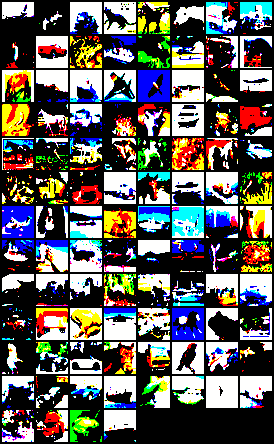

In [14]:
import IPython

display(IPython.display.Image(os.path.join('ae_images', 'x_hat.png'),width=900))

#### Denoising auto encoder

In [15]:
enc = ResNet(BasicBlock, [2,2,2,2])
dec = Decoder()

enc.to(aDev)
dec.to(aDev)

Decoder(
  (features): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
)

In [ ]:
for i in range(50):
    for images, _ in train:
        images_n = torch.mul(images+0.25, 0.1*torch.rand(100,3,32,32))
        images = images.cuda()
        images_n = images_n.cuda()
        optimizer.zero_grad()
        output = enc(images_n)
        output = dec(output)
        loss = loss_func(output, images)
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(i + 1, 50, loss.item()))

torch.save(enc.state_dict(), 'enc_cae.th')
torch.save(dec.state_dict(), 'dec_cae.th')

In [16]:
enc.load_state_dict(torch.load("enc_cae.th"))
dec.load_state_dict(torch.load("dec_cae.th"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [18]:
for images, _ in test:
    images_n = torch.mul(images+0.25, 0.1*torch.rand(100,3,32,32))
    images_n = images_n.cuda()
    enc_out = enc(images_n)
    dec_out = dec(enc_out)
    x_hat = to_img(dec_out.cpu())
    save_image(x_hat, './ae_images/x_hat_cae.png')
    break

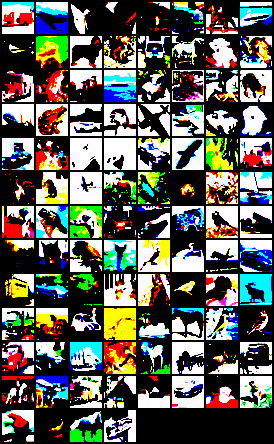

In [19]:
display(IPython.display.Image(os.path.join('ae_images', 'x_hat_cae.png'),width=900))

#### CIFAR classification in latent space

In [7]:
enc = ResNet(BasicBlock, [2,2,2,2])
enc.to(aDev)
enc.load_state_dict(torch.load("enc_ae.th"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
import pickle

f = open("latent_representation", "wb")
train_labels = []

for images, labels in train:
    images, labels = images.cuda(), labels.cuda()
    latent_space = enc(images)
    pickle.dump(latent_space, f)
    train_labels.append(labels)
    
f.close()

f = open("latent_representation_test", "wb")
test_labels = []

for images, labels in test:
    latent_space = enc(images)
    pickle.dump(latent_space, f)
    test_labels.append(labels)
    
f.close()

In [29]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(256,512,3,padding=1),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2,2)
                                     )
        self.classifier = nn.Sequential(nn.Dropout(0.3),
                                        nn.Linear(512*4*4, 256),
                                        nn.ReLU(),
                                        nn.Dropout(0.3),
                                        nn.Linear(256,10),
                                        nn.LogSoftmax()
                                       )
    def forward(self, x):
        out = self.features(x)
        out = out.view(x.shape[0], -1)
        out = self.classifier(out)
        return out

In [45]:
conv_net = ConvNet()

conv_net.to(aDev)

loss_func = nn.CrossEntropyLoss()
loss_func.to(aDev)

optimizer = Adam(conv_net.parameters(), lr=0.001)

for i in range(20):
    f = open("latent_representation", "rb")
    running_loss = 0
    conv_net.train()
    for idx in range(500):
        images = pickle.load(f)
        images = images.cuda()
        optimizer.zero_grad()
        output = conv_net(images)
        loss = loss_func(output, train_labels[idx].cuda())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    f.close()
    conv_net.eval()
    total, correct = 0, 0
    f = open("latent_representation_test", "rb")
    for j in range(100):
        images = pickle.load(f)
        images = images.cuda()
        labels = test_labels[j].cuda()
        outputs = conv_net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum().float()

    accuracy = 100. * correct /total
    f.close()
    print('epoch [{}/{}], train loss:{:.4f}, val accuracy: {}'.format(i + 1, 20, running_loss/600., accuracy))
    
torch.save(conv_net.state_dict(), 'conv_net_latent.th')

epoch [1/20], train loss:1.4611, val accuracy: 46.380001068115234
epoch [2/20], train loss:1.2515, val accuracy: 50.209999084472656
epoch [3/20], train loss:1.1517, val accuracy: 53.209999084472656
epoch [4/20], train loss:1.0757, val accuracy: 53.560001373291016
epoch [5/20], train loss:1.0032, val accuracy: 55.16999816894531
epoch [6/20], train loss:0.9348, val accuracy: 56.119998931884766
epoch [7/20], train loss:0.8750, val accuracy: 56.880001068115234
epoch [8/20], train loss:0.8142, val accuracy: 57.75
epoch [9/20], train loss:0.7618, val accuracy: 55.65999984741211
epoch [10/20], train loss:0.7073, val accuracy: 57.43000030517578
epoch [11/20], train loss:0.6602, val accuracy: 56.599998474121094
epoch [12/20], train loss:0.6174, val accuracy: 56.43000030517578
epoch [13/20], train loss:0.5754, val accuracy: 56.81999969482422
epoch [14/20], train loss:0.5341, val accuracy: 57.290000915527344
epoch [15/20], train loss:0.5099, val accuracy: 57.13999938964844
epoch [16/20], train lo